In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/module-examples/features_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# deeptrack.features

This example introduces the module deeptrack.features.

## 1. What is a feature?

Features are instances of the abstract class `Feature` and are responsible for creating and altering images. For example, a feature might add a particle or add some salt-and-pepper noise to an image.

All features operate on lists of images. Most features, such as noise, apply some tranformation to all images in the list. This transformation can be additive, such as adding some Gaussian noise or a background illumination, or non-additive, such as introducing Poisson noise or performing a low-pass filter. This transformation is defined by the method `get(image, **kwargs)`, which all implementations of the class `Feature` need to define.

Some features, for example scattterers, instead, append a new image to the list. This behavior is controlled by the class attributes `__distributed__` and `__list_merge_strategy__`:
* `__distributed__` controls whether `.get(image, **kwargs)` is called on each element in the list separately (`__distributed__ = True`), or it is called on the list as a whole (`__distributed__ = False`).  
* `__list_merge_strategy__` controls how the output of `.get(image, **kwargs)` is merged with the input list. It can be `MERGE_STRATEGY_OVERRIDE` (0, default), where the new list is output without merging with the input, or `MERGE_STRATEGY_APPEND` (1), where the new list is appended to the end of the input list.

When a feature is created, keyword arguments can be passed to its constructor. These arguments are stored as properties (as a `PropertyDict`) of the feature (see also [properties_example](properties_example.ipynb)), which determine how the feature is resolved. When a feature is updated using the method `.update()`, all properties are updated by calling their respective methods `.update()`. When a feature is called, the current values of all properties are sent through the method `get(image, **kwargs)` as keyword arguments.

In [2]:
import numpy as np
from deeptrack.features import Feature

# Implementation of abstract class Feature 
# which does not alter the input image 
# and prints the current value of my_property.
class Foo(Feature):

    # Controls what is passed to the method get(): 
    # False: everything is passed without modification.
    # True: elements along the first axis are passed separately.
    __distributed__ = False

    def get(self, image, my_property=None, **kwargs):
        print("The current value of my_property is", my_property)
        return image



foo1 = Foo(my_property=1)
foo1.update()
output_image = foo1()

foo2 = Foo(my_property="bar")
foo2.update()
output_image = foo2()

foo3 = Foo()
foo3.update()
output_image = foo3()

The current value of my_property is 1
The current value of my_property is bar
The current value of my_property is None


Since the values are stored as instances of the class `Property`, we can always replace values with standard structures (e.g., lists or lambda functions) to create more complex behaviors (see also [properties_example](properties_example.ipynb)).

In [3]:
foo4 = Foo(my_property=lambda: np.random.rand() - 0.5)
foo4.update()
output_image = foo4()

# Pick one random element from the list.
foo5 = Foo(my_property=lambda: np.random.choice(["bar", "baz"]))
foo5.update()
output_image = foo5()

The current value of my_property is -0.14604639872319003
The current value of my_property is baz


## 2. Operations defined on features

Features can be combined to create a feature series, which is a series of features that are evaluated sequentially. This is done using the add operator (+), the multiply operator (\*), and the power operator (\*\*).

### Chaining features

The rshft operator (>>) combines two features such that they are evaluated sequentially. For example, given the features `foo` and `bar`, we can combine them as `foobar = foo >> bar`. When `foobar` resolves an image, it first resolves an image from `foo`, then uses this image as the input to resolve an image from `bar`.

This operation returns an instance of the feature `Branch`, which contains the two features.

In [4]:
foobar = Foo(my_property="foo") >> Foo(my_property="bar")

foobar.update()
output_image = foobar()

The current value of my_property is foo
The current value of my_property is bar


### Repeating a feature (^) 

The xor operator (^) takes a feature `foo` and an integer `i` and creates a feature which will call the feature five times with different sets of properties. For example, `foo^5` will call Foo five times. Since this is done at resolve time, the exponent can be any expression that returns an integer when evaluated.

This operation returns an instance of the feature `Repeat`, which contains the original feature and the number of times it should be repeated.

In [5]:
foo = Foo(my_property=lambda: np.random.choice(["bar", "baz", "qux", "quux"])) 

five_foos = foo^5
five_foos.update()
output_image = five_foos()

The current value of my_property is baz
The current value of my_property is bar
The current value of my_property is quux
The current value of my_property is baz
The current value of my_property is baz


In [6]:
number_of_foo = lambda: np.random.randint(0, 10)

random_foos = foo^number_of_foo
random_foos.update()

# Pick one random exponent from the list.
output_image = random_foos()


The current value of my_property is qux


## 3. Example - Image with random circles

Simple example that generates an image with some random circles.

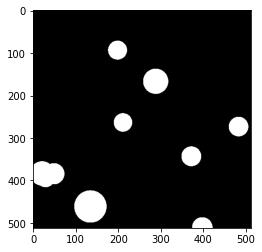

In [7]:
from matplotlib import pyplot as plt

# Implementation of the abstract class Feature that draws a circle on an image.
class Circle(Feature):

    def get(self, image, position, radius, intensity, **kwargs):
        X, Y = np.meshgrid(np.arange(image.shape[0]),
                           np.arange(image.shape[1]))
        mask = (X - position[0])**2 + (Y - position[1])**2 < radius**2
        image[mask] = intensity
        return image

circle = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1
)

input_image = np.zeros((512, 512))
circles = circle^10
circles.update()
output_image = circles.resolve(input_image) 

from matplotlib import pyplot as plt
plt.imshow(output_image, cmap='gray')
plt.show()

## 4. Example - Image with stacked circles

And now a more complex example. In this case, we have a repeated feature that depends on another feature.

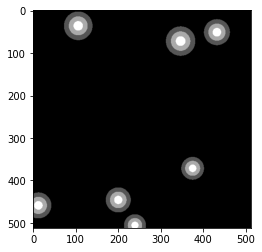

In [8]:
circle1 = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1
)

circle2 = Circle(
    position=circle1.position,
    radius=circle1.radius * 0.66,
    intensity=2
)

circle3 = Circle(
    position=circle1.position,
    radius=circle1.radius * 0.33,
    intensity=3
)

stacked_circles = circle1 >> circle2 >> circle3

many_stacked_circles = stacked_circles ^ (lambda: np.random.randint(5, 10))
        
input_image = np.zeros((512, 512))
output_image = many_stacked_circles.update()(input_image) 

plt.imshow(output_image, cmap='gray')
plt.show()